In [7]:
import torch
from torch import nn
from typing import List
import torch.nn.functional as F
from transformers import DistilBertTokenizer, AutoTokenizer, AutoModelWithLMHead, AutoModel, AdamW, get_linear_schedule_with_warmup
import logging
import os
from functools import lru_cache
from tokenizers import ByteLevelBPETokenizer
from tokenizers.processors import BertProcessing
import pytorch_lightning as pl
from torch.utils.data import DataLoader, Dataset
import pandas as pd
from argparse import Namespace
from sklearn.metrics import classification_report
torch.__version__

'2.5.1+cu121'

## Load the Pretrained Language Model
We will use a variant of BERT, called DistilRoBERTa base provided by HuggingFace models. The `base` model has less parameters than the `larger` model.

[RoBERTa](https://arxiv.org/abs/1907.11692) is a variant of of BERT which "*modifies key hyperparameters, removing the next-sentence pretraining objective and training with much larger mini-batches and learning rates*".

Knowledge distillation help to train smaller LMs with similar performance and potential.

In [8]:
tokenizer = AutoTokenizer.from_pretrained('distilroberta-base')

In [9]:
model = AutoModel.from_pretrained("distilroberta-base")
base_model = model.base_model

In [10]:
text = "Elvis is the king of rock!"
enc = tokenizer.encode_plus(text)
enc.keys()
out = base_model(torch.tensor(enc["input_ids"]).unsqueeze(0), torch.tensor(enc["attention_mask"]).unsqueeze(0))
out[0].shape

torch.Size([1, 10, 768])

In [11]:
## size of representation of one of the tokens
out[0][:,0,:].shape, out[0].shape, out[0]

(torch.Size([1, 768]),
 torch.Size([1, 10, 768]),
 tensor([[[-0.0384,  0.0482, -0.0128,  ...,  0.0148, -0.0885,  0.0388],
          [ 0.0312,  0.2362, -0.0594,  ..., -0.0862, -0.0779,  0.0986],
          [-0.0213,  0.2983, -0.0144,  ...,  0.1338, -0.0386,  0.1351],
          ...,
          [-0.1052,  0.0377, -0.0083,  ...,  0.1869, -0.0304,  0.0325],
          [-0.0163, -0.0976,  0.0186,  ..., -0.2109, -0.1637,  0.1759],
          [-0.0542,  0.0595, -0.0695,  ..., -0.0484, -0.1007,  0.0362]]],
        grad_fn=<NativeLayerNormBackward0>))

`torch.Size([1, 768])` represents batch_size, number of tokens in input text (lenght of tokenized text), model's output hidden size.

In [12]:
t = "Elvis is the king of rock"
enc = tokenizer.encode_plus(t)
token_representations = base_model(torch.tensor(enc["input_ids"]).unsqueeze(0))[0][0]
print(enc["input_ids"])
print(tokenizer.decode(enc["input_ids"]))
print(f"Length: {len(enc['input_ids'])}")
print(token_representations.shape)

[0, 9682, 9578, 16, 5, 8453, 9, 3152, 2]
<s>Elvis is the king of rock</s>
Length: 9
torch.Size([9, 768])


## Building Custom Classification head on top of LM base model

Use Mish activiation function

In [13]:
# from https://github.com/digantamisra98/Mish/blob/b5f006660ac0b4c46e2c6958ad0301d7f9c59651/Mish/Torch/mish.py
@torch.jit.script
def mish(input):
    return input * torch.tanh(F.softplus(input))

class Mish(nn.Module):
    def forward(self, input):
        return mish(input)

The model we will use to do the fine-tuning

In [14]:
class EmoModel(nn.Module):
    def __init__(self, base_model, n_classes, base_model_output_size=768, dropout=0.05):
        super().__init__()
        self.base_model = base_model

        self.classifier = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(base_model_output_size, base_model_output_size),
            Mish(),
            nn.Dropout(dropout),
            nn.Linear(base_model_output_size, n_classes)
        )

        for layer in self.classifier:
            if isinstance(layer, nn.Linear):
                layer.weight.data.normal_(mean=0.0, std=0.02)
                if layer.bias is not None:
                    layer.bias.data.zero_()

    def forward(self, input_, *args):
        X, attention_mask = input_
        hidden_states = self.base_model(X, attention_mask=attention_mask)

        # maybe do some pooling / RNNs... go crazy here!

        # use the <s> representation
        return self.classifier(hidden_states[0][:, 0, :])

### Pretest the model with dummy text
We want to ensure that the model is returing the right information back.

In [30]:
classifier = EmoModel(AutoModel.from_pretrained("distilroberta-base").base_model, 3)

In [16]:
X = torch.tensor(enc["input_ids"]).unsqueeze(0).to('cpu')
attn = torch.tensor(enc["attention_mask"]).unsqueeze(0).to('cpu')

In [17]:
classifier((X, attn))

tensor([[-0.0798, -0.0651, -0.1433]], grad_fn=<AddmmBackward0>)

## Prepare dataset for fine-tuning

In [ ]:
!mkdir -p tokenizer

In [19]:
## load pretrained tokenizer information
tokenizer.save_pretrained("tokenizer")

('tokenizer\\tokenizer_config.json',
 'tokenizer\\special_tokens_map.json',
 'tokenizer\\vocab.json',
 'tokenizer\\merges.txt',
 'tokenizer\\added_tokens.json',
 'tokenizer\\tokenizer.json')

Implement CollateFN using fast tokenizers.

In [20]:
class TokenizersCollateFn:
    def __init__(self, max_tokens=512):

        ## RoBERTa uses BPE tokenizer similar to GPT
        t = ByteLevelBPETokenizer(
            "tokenizer/vocab.json",
            "tokenizer/merges.txt"
        )
        t._tokenizer.post_processor = BertProcessing(
            ("</s>", t.token_to_id("</s>")),
            ("<s>", t.token_to_id("<s>")),
        )
        t.enable_truncation(max_tokens)
        t.enable_padding(length=max_tokens, pad_id=t.token_to_id("<pad>"))
        self.tokenizer = t

    def __call__(self, batch):
        encoded = self.tokenizer.encode_batch([x[0] for x in batch])
        sequences_padded = torch.tensor([enc.ids for enc in encoded])
        attention_masks_padded = torch.tensor([enc.attention_mask for enc in encoded])
        labels = torch.tensor([x[1] for x in batch])

        return (sequences_padded, attention_masks_padded), labels

## Getting the Data and Preview it

In [21]:
## export the datasets as txt files
## EXERCISE: Change this to an address

train_path = "train.txt"
test_path = "test.txt"
val_path = "val.txt"

## emotion labels
label2int = {
  "sadness": 0,
  "joy": 1,
  "love": 2,
  "anger": 3,
  "fear": 4,
  "surprise": 5
}

emotions = [ "sadness", "joy", "love", "anger", "fear", "surprise"]

## Split the data and store into individual text files

If you are using your own dataset and want to split it for training, you can uncomment the code below. Otherwise, just skip it.

In [22]:
## uncomment the code below to generate the text files for your train, val, and test datasets.


from sklearn.model_selection import train_test_split
import numpy as np

from datasets import load_dataset

# load the dataset
ds = load_dataset("dair-ai/emotion")

# extract the train, validation, and test splits
train_data = ds["train"]
validation_data = ds["validation"]
test_data = ds["test"]

input_train = train_data["text"]
target_train = train_data["label"]

input_val = validation_data["text"]
target_val = validation_data["label"]

input_test = test_data["text"]
target_test = test_data["label"]

# build DataFrame
train_dataset = pd.DataFrame(data={"text": input_train, "class": target_train})
val_dataset = pd.DataFrame(data={"text": input_val, "class": target_val})
test_dataset = pd.DataFrame(data={"text": input_test, "class": target_test})

#store the datasets in the csv format
train_dataset.to_csv(train_path, sep=";", header=False, index=False)
val_dataset.to_csv(val_path, sep=";", header=False, index=False)
test_dataset.to_csv(test_path, sep=";", header=False, index=False)



## Create the Dataset object

Create the Dataset object that will be used to load the different datasets.

In [23]:
class EmoDataset(Dataset):
    def __init__(self, path):
        super().__init__()
        self.data_column = "text"
        self.class_column = "class"
        self.data = pd.read_csv(path, sep=";", header=None, names=[self.data_column, self.class_column],
                               engine="python")

    def __getitem__(self, idx):
        return self.data.loc[idx, self.data_column], int(self.data.loc[idx, self.class_column])

    def __len__(self):  
        return self.data.shape[0]

Sanity check

In [24]:
ds = EmoDataset(train_path)
ds[19]

('i now feel compromised and skeptical of the value of every unit of work i put in',
 4)

## Training with PyTorchLightning

[PyTorchLightning](https://www.pytorchlightning.ai/) is a library that abstracts the complexity of training neural networks with PyTorch. It is built on top of PyTorch and simplifies training.

![](https://pytorch-lightning.readthedocs.io/en/latest/_images/pt_to_pl.png)

In [32]:
## Methods required by PyTorchLightning

class TrainingModule(pl.LightningModule):
    def __init__(self, hparams):
        super().__init__()
        self.model = EmoModel(AutoModel.from_pretrained("distilroberta-base").base_model, len(emotions))
        self.loss = nn.CrossEntropyLoss() ## combines LogSoftmax() and NLLLoss()
        #self.hparams = hparams
        self.hparams.update(vars(hparams))

    def step(self, batch, step_name="train"):
        X, y = batch
        loss = self.loss(self.forward(X), y)
        loss_key = f"{step_name}_loss"
        tensorboard_logs = {loss_key: loss}

        return { ("loss" if step_name == "train" else loss_key): loss, 'log': tensorboard_logs,
               "progress_bar": {loss_key: loss}}

    def forward(self, X, *args):
        return self.model(X, *args)

    def training_step(self, batch, batch_idx):
        return self.step(batch, "train")

    def validation_step(self, batch, batch_idx):
        return self.step(batch, "val")

    def validation_end(self, outputs: List[dict]):
        loss = torch.stack([x["val_loss"] for x in outputs]).mean()
        return {"val_loss": loss}

    def test_step(self, batch, batch_idx):
        return self.step(batch, "test")

    def train_dataloader(self):
        return self.create_data_loader(self.hparams.train_path, shuffle=True)

    def val_dataloader(self):
        return self.create_data_loader(self.hparams.val_path)

    def test_dataloader(self):
        return self.create_data_loader(self.hparams.test_path)

    def create_data_loader(self, ds_path: str, shuffle=False):
        return DataLoader(
                    EmoDataset(ds_path),
                    batch_size=self.hparams.batch_size,
                    shuffle=shuffle,
                    collate_fn=TokenizersCollateFn()
        )

    @lru_cache()
    def total_steps(self):
        return len(self.train_dataloader()) // self.hparams.accumulate_grad_batches * self.hparams.epochs

    def configure_optimizers(self):
        ## use AdamW optimizer -- faster approach to training NNs
        ## read: https://www.fast.ai/2018/07/02/adam-weight-decay/
        optimizer = AdamW(self.model.parameters(), lr=self.hparams.lr)
        lr_scheduler = get_linear_schedule_with_warmup(
                    optimizer,
                    num_warmup_steps=self.hparams.warmup_steps,
                    num_training_steps=self.total_steps(),
        )
        return [optimizer], [{"scheduler": lr_scheduler, "interval": "step"}]

## Finding Learning rate for the model

The code below aims to obtain valuable information about the optimal learning rate during a pretraining run. Determine boundary and increase the leanring rate linearly or exponentially.

c:\Users\10107\Downloads\robert\.venv\Lib\site-packages\transformers\optimization.py:640: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/100 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 1.64E-04


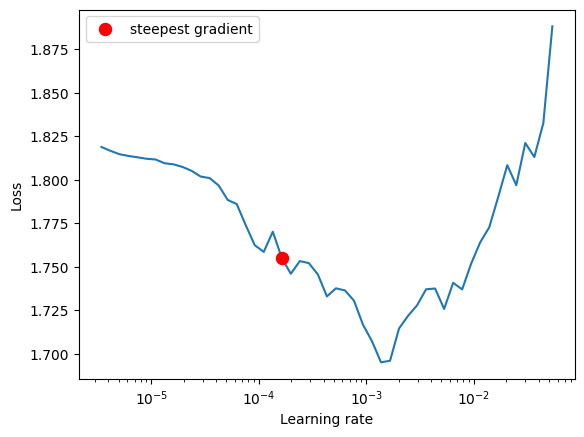

In [33]:
lr=0.1 ## uper bound LR
from torch_lr_finder import LRFinder
hparams_tmp = Namespace(
    train_path=train_path,
    val_path=val_path,
    test_path=test_path,
    batch_size=16,
    warmup_steps=100,
    epochs=1,
    lr=lr,
    accumulate_grad_batches=1,
)
module = TrainingModule(hparams_tmp)
criterion = nn.CrossEntropyLoss()
optimizer = AdamW(module.parameters(), lr=5e-7) ## lower bound LR
lr_finder = LRFinder(module, optimizer, criterion, device="cuda")
lr_finder.range_test(module.train_dataloader(), end_lr=100, num_iter=100, accumulation_steps=hparams_tmp.accumulate_grad_batches)
lr_finder.plot()
lr_finder.reset()

LR suggestion: steepest gradient
Suggested LR: 1.64E-04


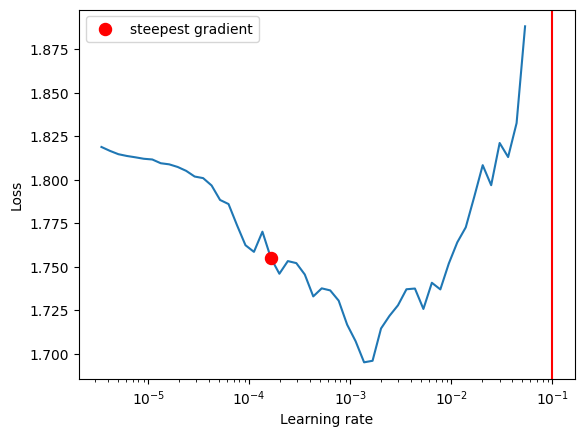

(<Axes: xlabel='Learning rate', ylabel='Loss'>, 0.00016384516851638498)

In [34]:
lr_finder.plot(show_lr=lr)

## Training the Emotion Classifier

In [35]:
hparams = Namespace(
    train_path=train_path,
    val_path=val_path,
    test_path=test_path,
    batch_size=32,
    warmup_steps=100,
    epochs=2,
    lr=lr,
    accumulate_grad_batches=1
)
module = TrainingModule(hparams)

In [36]:
## garbage collection
import gc; gc.collect()
torch.cuda.empty_cache()

In [37]:
## train roughly for about 10-15 minutes with GPU enabled.
trainer = pl.Trainer(devices=1, accelerator="gpu", max_epochs=hparams.epochs,
                     accumulate_grad_batches=hparams.accumulate_grad_batches)

trainer.fit(module)

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\10107\Downloads\robert\.venv\Lib\site-packages\pytorch_lightning\trainer\connectors\logger_connector\logger_connector.py:76: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
You are using a CUDA device ('NVIDIA GeForce RTX 4060 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off pre

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\10107\Downloads\robert\.venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
c:\Users\10107\Downloads\robert\.venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=2` reached.


In [40]:
with torch.no_grad():
    progress = ["/", "-", "\\", "|", "/", "-", "\\", "|"]
    module.eval()
    module.to('cuda')
    true_y, pred_y = [], []
    for i, batch_ in enumerate(module.test_dataloader()):
        (X, attn), y = batch_
        batch = (X.cuda(), attn.cuda())
        print(progress[i % len(progress)], end="\r")
        y_pred = torch.argmax(module(batch), dim=1)
        true_y.extend(y.cpu())
        pred_y.extend(y_pred.cpu())
print("\n" + "_" * 80)
print(classification_report(true_y, pred_y, target_names=label2int.keys(), digits=len(emotions)))

\
________________________________________________________________________________
              precision    recall  f1-score   support

     sadness   0.000000  0.000000  0.000000       581
         joy   0.347500  1.000000  0.515770       695
        love   0.000000  0.000000  0.000000       159
       anger   0.000000  0.000000  0.000000       275
        fear   0.000000  0.000000  0.000000       224
    surprise   0.000000  0.000000  0.000000        66

    accuracy                       0.347500      2000
   macro avg   0.057917  0.166667  0.085962      2000
weighted avg   0.120756  0.347500  0.179230      2000



c:\Users\10107\Downloads\robert\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\10107\Downloads\robert\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\10107\Downloads\robert\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
!nvidia-smi

Sat Apr  2 02:35:31 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   50C    P0    61W / 149W |  11259MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------